In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
import math
import random
from PIL import Image
import torch.optim as optim

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### prepare train, val, test dataset

In [3]:
data_path = "./images"

label_list = []

train = []
val = []
test = []

train_label = []
val_label = []
test_label = []

label_idx = 0

for folder in os.listdir(data_path):
    label = folder.split("-")[1]
    temp_lab = []
    temp_lab.append(label_idx)
    temp_lab.append(label)
    label_list.append(temp_lab)
    #print(label)
    count = 0
    for image in os.listdir(os.path.join(data_path, folder)):
        count+=1
    
    count2 = int(math.ceil(count/10))
  

    temp = []
    temp_label = []
    for image in os.listdir(os.path.join(data_path, folder)):
        t = []
        t.append(os.path.join(data_path, folder, image))
        t.append(label_idx)
        t.append(label)
        temp.append(t)
    random.shuffle(temp)
        
    temp_train = temp[0:count-count2-count2]
    temp_val = temp[count-count2-count2:count-count2]
    temp_test = temp[count-count2:]
    
    train.extend(temp_train)
    val.extend(temp_val)
    test.extend(temp_test)
    
    label_idx+=1
    
random.shuffle(train)
random.shuffle(val)
random.shuffle(test)

train_data = [x[0] for x in train]
train_label = [x[1] for x in train]

val_data = [x[0] for x in val]
val_label = [x[1] for x in val]

test_data = [x[0] for x in test]
test_label = [x[1] for x in test]

### Customize dataset

In [4]:
class ImageDataset(Dataset):
    def __init__(self, img, label, transform):        
        self.img = img
        self.label = label
        self.transform = transform
        
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, idx):
        image = Image.open(self.img[idx]).convert('RGB')
        return self.transform(image), self.label[idx]

### find mean and std for normalize

In [5]:
#train_transform = transforms.Compose([
#    transforms.Resize((299,299)),
#    transforms.CenterCrop(299),
#    transforms.RandomHorizontalFlip(),
#    transforms.ToTensor()
#])
#
#test_transform = transforms.Compose([
#    transforms.Resize((299,299)), 
#    transforms.CenterCrop(299),
#    transforms.ToTensor()
#])

In [6]:
#training_data = ImageDataset(train_data, train_label, train_transform)
#train_dataloader = DataLoader(training_data, batch_size=len(training_data), shuffle=True)
#images, labels = next(iter(train_dataloader))

In [7]:
#def mean_std(img):
#    mean = img.mean([0,2,3])
#    std = img.std([0,2,3])
#    return mean, std
#
#mean, std = mean_std(images)
#print("mean and std: \n", mean, std)

### create dataloader for train, val, test

In [8]:
train_transform_norm = transforms.Compose([
    transforms.Resize((299,299)),
    transforms.CenterCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4757, 0.4519, 0.3907],
                         std= [0.2592, 0.2537, 0.2582])
])

test_transform_norm = transforms.Compose([
    transforms.Resize((299,299)), 
    transforms.CenterCrop(299),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.4757, 0.4519, 0.3907],
                         std= [0.2592, 0.2537, 0.2582])
])

In [9]:
training_data = ImageDataset(train_data, train_label, train_transform_norm)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

valing_data = ImageDataset(val_data, val_label, test_transform_norm)
val_dataloader = DataLoader(valing_data, batch_size=32, shuffle=False)

testing_data = ImageDataset(test_data, test_label, test_transform_norm)
test_dataloader = DataLoader(testing_data, batch_size=32, shuffle=False)

### load pretrained model and weights

In [10]:
model = torchvision.models.resnet50(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
model.fc = nn.Sequential(
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Linear(1024, 120))

model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

### train

In [12]:
# Loss function
loss_fun = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.000005)
#softmax
softmax = nn.Softmax(dim=1)

In [13]:
# put model into cuda
model.to(device)
model.train() # start training

best_model_parameters1 = None
best_loss1 = None
iteration1 = 0

val_loss_list = []
val_accuracy_list = []

for i in range(50):
    train_loss = []
    accuracy = []
    for j, (data, label) in enumerate(train_dataloader):
        # put data, label into CUDA
        data = data.to(device)
        label = label.to(device)
        optimizer.zero_grad() # Sets the gradients to zero.
        output = model(data) # get output from model
        loss = loss_fun(output, label) # calculate loss
        loss.backward() # Back propagation
        optimizer.step() # update gradients
        
    val_loss = 0
    accuracy = 0
    with torch.no_grad(): # deactivates autograd
        for j, (data, label) in enumerate(val_dataloader):
            # put data, label into CUDA
            data = data.to(device)
            label = label.to(device)

            output = model(data) # get output from model
            loss = loss_fun(output, label)# calculate loss
            val_loss += loss.item() # accumulate loss
            prediction = softmax(output).argmax(1) # get prediction
            accuracy += (prediction == label).sum().item() # accumulate accuracy

    val_loss = val_loss/len(val_dataloader.dataset) # calculate average loss
    accuracy = accuracy/len(val_dataloader.dataset) # calculate average accuracy
    
    
    # save best model with the lowest val loss
    if best_loss1 is None:
        iteration1 = i
        best_loss1 = val_loss
        best_model_parameters1 = model.state_dict()
    elif best_loss1 > val_loss:
        iteration1 = i
        best_loss1 = val_loss
        best_model_parameters1 = model.state_dict()
    
    val_loss_list.append(val_loss)
    val_accuracy_list.append(accuracy)
    print("Epoch: {}\tValidation loss: {}\tValidation accuracy: {}".format(i, val_loss, accuracy))

Epoch: 0	Validation loss: 0.12649851930084952	Validation accuracy: 0.4246445497630332
Epoch: 1	Validation loss: 0.0930598489481126	Validation accuracy: 0.5611374407582939
Epoch: 2	Validation loss: 0.06759212971863589	Validation accuracy: 0.666824644549763
Epoch: 3	Validation loss: 0.0513423098772058	Validation accuracy: 0.7260663507109004
Epoch: 4	Validation loss: 0.04147904715831811	Validation accuracy: 0.7549763033175355
Epoch: 5	Validation loss: 0.03499828255007052	Validation accuracy: 0.7786729857819905
Epoch: 6	Validation loss: 0.030663565126075563	Validation accuracy: 0.7876777251184834
Epoch: 7	Validation loss: 0.027499964663767702	Validation accuracy: 0.7990521327014218
Epoch: 8	Validation loss: 0.025144450472429466	Validation accuracy: 0.8004739336492891
Epoch: 9	Validation loss: 0.023725882751681793	Validation accuracy: 0.8118483412322275
Epoch: 10	Validation loss: 0.022128120869821848	Validation accuracy: 0.8156398104265403
Epoch: 11	Validation loss: 0.021096128677304888	Val

### loss and accuracy for last epoch

In [14]:
test_loss = 0
accuracy = 0

with torch.no_grad(): # deactivates autograd
    for j, (data, label) in enumerate(test_dataloader):
        # put data, label into CUDA
        data = data.to(device)
        label = label.to(device)
        output = model(data) # get output prob
        loss = loss_fun(output, label) # get loss
        test_loss += loss.item() # accumulate loss
        prediction = softmax(output).argmax(1) # get prediction
        accuracy += (prediction == label).sum().item() # accumulate accuracy
        
test_loss = test_loss/len(test_dataloader.dataset) # calculate average loss
accuracy = accuracy/len(test_dataloader.dataset) # calculate average accuracy

print("Model in last epoch: Test loss: {}\tTest accuracy: {}".format(test_loss, accuracy))

Model in last epoch: Test loss: 0.020664563700909862	Test accuracy: 0.8350710900473933


### loss and accuracy for best epoch

In [15]:
model.load_state_dict(best_model_parameters1) # load the weight parameters from the saved best model

val_loss = 0
accuracy = 0
with torch.no_grad(): # deactivates autograd
    for j, (data, label) in enumerate(test_dataloader):
        # put data, label into CUDA
        data = data.to(device)
        label = label.to(device)

        output = model(data) # get output from model
        loss = loss_fun(output, label)# calculate loss
        val_loss += loss.item() # accumulate loss
        prediction = softmax(output).argmax(1) # get prediction
        accuracy += (prediction == label).sum().item() # accumulate accuracy

val_loss = val_loss/len(test_dataloader.dataset) # calculate average loss
accuracy = accuracy/len(test_dataloader.dataset) # calculate average accuracy

print("Best epoch: ", iteration1)
print("Test loss: {}\tTest accuracy: {}".format(test_loss, accuracy))

Best epoch:  20
Test loss: 0.020664563700909862	Test accuracy: 0.8350710900473933


### val accuracy per epochs during training

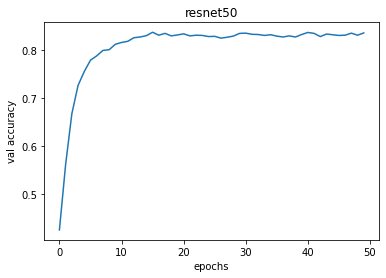

In [16]:
x_axis = [i for i in range(50)]

plt.plot(x_axis, val_accuracy_list)
plt.title('resnet50')
plt.xlabel('epochs')
plt.ylabel('val accuracy')
plt.show()

### val loss per epochs during training

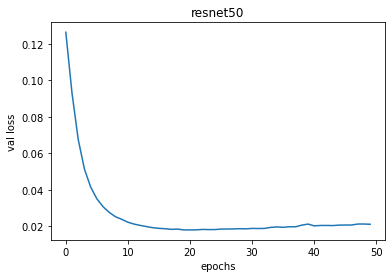

In [18]:
x_axis = [i for i in range(50)]

plt.plot(x_axis, val_loss_list)
plt.title('resnet50')
plt.xlabel('epochs')
plt.ylabel('val loss')
plt.show()